<a href="https://colab.research.google.com/github/arturodeleon19/Data-Science-Projects/blob/main/Fruit%20Image%20Classification/Fruit_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("icebearogo/fruit-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fruit-classification-dataset


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib.ticker import MaxNLocator
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
def print_all_files(directory='.'):
    for root, _, files in os.walk(directory):
        for file in files:
            print(os.path.join(root, file))


print_all_files('/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1')


Streaming output truncated to the last 5000 lines.
/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1/banana/24.jpg
/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1/banana/947.jpg
/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1/banana/1043.jpg
/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1/banana/926.jpg
/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1/banana/465.jpg
/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1/banana/352.jpg
/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1/banana/269.jpg
/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1/banana/955.jpg
/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1/banana/485.jpg
/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1/banana/216.jpg
/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1/banana/587.jpg
/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1/banana/148.jpg
/

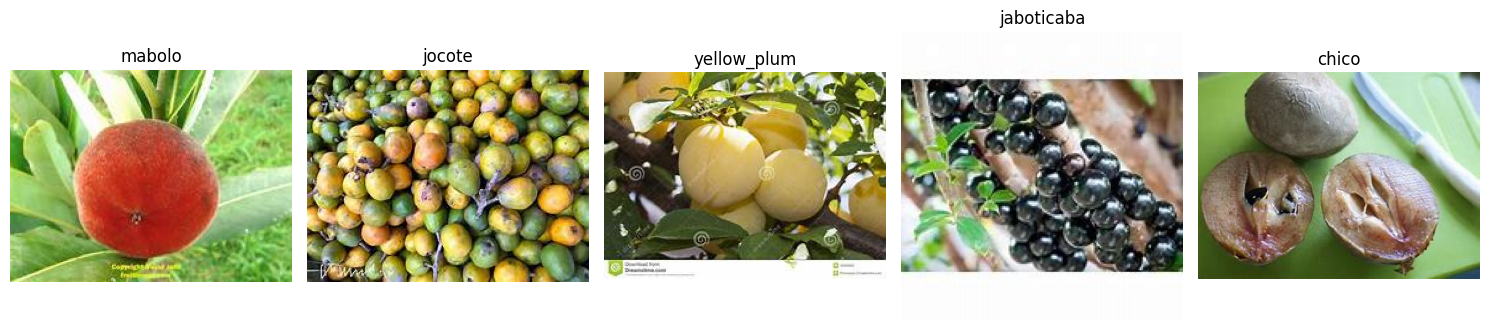

In [ ]:
def plot_random_images(dataset_path, num_images=5):
    """
    Plot random images from directory with labels.

    Args:
        dataset_path (str): Path to the dataset directory
        num_images (int): Number of random images to display
    """
    # Get class folders
    classes = [d for d in os.listdir(dataset_path)
               if os.path.isdir(os.path.join(dataset_path, d))]

    if not classes:
        print(f"No subdirectories found in {dataset_path}")
        return

    # Create plot
    plt.figure(figsize=(15, 10))

    for i in range(num_images):
        # Randomly select classes
        selected_class = random.choice(classes)
        class_path = os.path.join(dataset_path, selected_class)

        # Get images
        images = [f for f in os.listdir(class_path)
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if not images:
            print(f"No images found in {selected_class}")
            continue

        # Randomly select image
        selected_image = random.choice(images)
        img_path = os.path.join(class_path, selected_image)

        # Plot image
        img = imread(img_path)

        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(selected_class)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

train_path = '/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1'
plot_random_images(dataset_path = train_path, num_images=5)

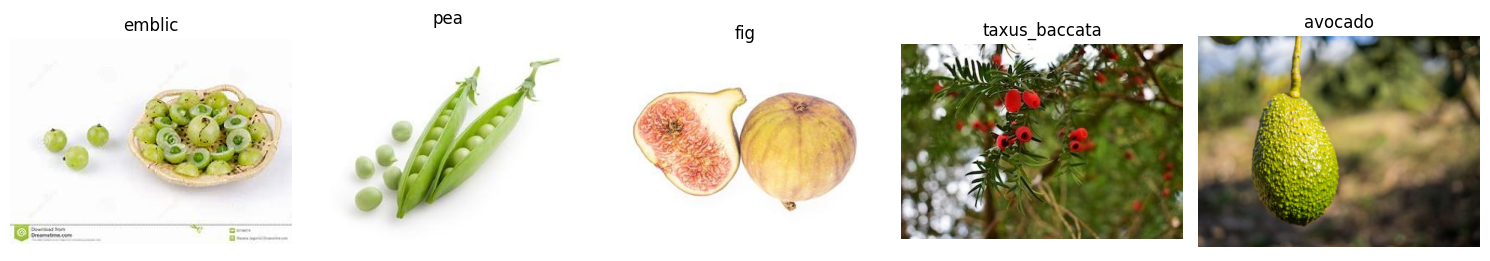

In [ ]:
val_path = '/kaggle/input/fruit-classification-dataset/Fruit_dataset/val1'
plot_random_images(dataset_path = val_path, num_images=5)

In [ ]:
# Define train and val paths
train_path = "/kaggle/input/fruit-classification-dataset/Fruit_dataset/train1"
val_path = "/kaggle/input/fruit-classification-dataset/Fruit_dataset/val1"

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Create training dataset
train_dataset = image_dataset_from_directory(
    train_path,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical',
    seed=42
)

# Create validation dataset
val_dataset = image_dataset_from_directory(
    val_path,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='categorical',
    seed=42
)

# Get class names
class_names = train_dataset.class_names

# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


# Print dataset information
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")
print(f"Training batches: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_dataset)}")

Found 40000 files belonging to 100 classes.
Found 5000 files belonging to 100 classes.
Number of classes: 100
Class names: ['abiu', 'acai', 'acerola', 'ackee', 'ambarella', 'apple', 'apricot', 'avocado', 'banana', 'barbadine', 'barberry', 'betel_nut', 'bitter_gourd', 'black_berry', 'black_mullberry', 'brazil_nut', 'camu_camu', 'cashew', 'cempedak', 'chenet', 'cherimoya', 'chico', 'chokeberry', 'cluster_fig', 'coconut', 'corn_kernel', 'cranberry', 'cupuacu', 'custard_apple', 'damson', 'dewberry', 'dragonfruit', 'durian', 'eggplant', 'elderberry', 'emblic', 'feijoa', 'fig', 'finger_lime', 'gooseberry', 'goumi', 'grape', 'grapefruit', 'greengage', 'grenadilla', 'guava', 'hard_kiwi', 'hawthorn', 'hog_plum', 'horned_melon', 'indian_strawberry', 'jaboticaba', 'jackfruit', 'jalapeno', 'jamaica_cherry', 'jambul', 'jocote', 'jujube', 'kaffir_lime', 'kumquat', 'lablab', 'langsat', 'longan', 'mabolo', 'malay_apple', 'mandarine', 'mango', 'mangosteen', 'medlar', 'mock_strawberry', 'morinda', 'moun

In [ ]:
inputs = layers.Input(shape=(224,224,3))

# Preprocessing (normalization)
x = layers.Rescaling(1./255)(inputs)

# Convolutional Base
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Classifier Head
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(100, activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile the Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)



# Training
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 45s 26ms/step - accuracy: 0.0132 - loss: 4.8054 - val_accuracy: 0.0270 - val_loss: 4.5027 - learning_rate: 1.0000e-04
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.0174 - loss: 4.5782 - val_accuracy: 0.0304 - val_loss: 4.4694 - learning_rate: 1.0000e-04
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.0234 - loss: 4.5219 - val_accuracy: 0.0432 - val_loss: 4.3756 - learning_rate: 1.0000e-04
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.0265 - loss: 4.4541 - val_accuracy: 0.0498 - val_loss: 4.3276 - learning_rate: 1.0000e-04
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.0310 - loss: 4.3909 - val_accuracy: 0.0664 - val_loss: 4.2039 - learning_rate: 1.0000e-04
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.0383 - loss: 4.3089 - val_accuracy: 0.0680 - val_loss: 4.1220 - learning_rate: 1.0000e-04
Epoch 7/100
1250/1250 ━━━━━━━━━━━━

In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

inputs = layers.Input(shape=(224,224,3))

# Data augmentation
x = data_augmentation(inputs)

# Preprocessing (normalization)
x = layers.Rescaling(1./255)(x)

# Convolutional Base
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Classifier Head
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(100, activation='softmax')(x)

model_2 = models.Model(inputs=inputs, outputs=outputs)

In [ ]:
# Compile the Model
model_2.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)



# Training
history_2 = model_2.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 52s 36ms/step - accuracy: 0.0101 - loss: 4.7775 - val_accuracy: 0.0196 - val_loss: 4.5693 - learning_rate: 1.0000e-04
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.0127 - loss: 4.5918 - val_accuracy: 0.0226 - val_loss: 4.5545 - learning_rate: 1.0000e-04
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 36ms/step - accuracy: 0.0141 - loss: 4.5748 - val_accuracy: 0.0210 - val_loss: 4.4816 - learning_rate: 1.0000e-04
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.0152 - loss: 4.5597 - val_accuracy: 0.0228 - val_loss: 4.5027 - learning_rate: 1.0000e-04
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.0143 - loss: 4.5436 - val_accuracy: 0.0282 - val_loss: 4.4276 - learning_rate: 1.0000e-04
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.0191 - loss: 4.4990 - val_accuracy: 0.0366 - val_loss: 4.3587 - learning_rate: 1.0000e-04
Epoch 7/100
1250/1250 ━━━━━━━━━━━━

In [ ]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.1),
])

# Load pre-trained model without top (classification) layer
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3)
)

# Freeze the base model
base_model.trainable = False

# Create new model on top
inputs = layers.Input(shape=(224,224,3))

# Apply data augmentation
x = data_augmentation(inputs)

# Preprocessing (normalization)
x = tf.keras.applications.efficientnet.preprocess_input(x)

# Base model
x = base_model(x, training=False)

# Add new layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(100, activation='softmax')(x)

model_3 = models.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# Compile the Model
model_3.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)


# Initial Training Phase (Frozen Base)
print("Training top layers only")
history_3_ENB0 = model_3.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)


Training top layers only
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 28ms/step - accuracy: 0.0967 - loss: 4.1395 - val_accuracy: 0.4996 - val_loss: 2.0609 - learning_rate: 1.0000e-04
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.3643 - loss: 2.4732 - val_accuracy: 0.5934 - val_loss: 1.5715 - learning_rate: 1.0000e-04
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.4557 - loss: 2.0384 - val_accuracy: 0.6274 - val_loss: 1.3737 - learning_rate: 1.0000e-04
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.5015 - loss: 1.8334 - val_accuracy: 0.6536 - val_loss: 1.2546 - learning_rate: 1.0000e-04
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.5382 - loss: 1.6749 - val_accuracy: 0.6754 - val_loss: 1.1728 - learning_rate: 1.0000e-04
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.5643 - loss: 1.5722 - val_accuracy: 0.6874 - val_loss: 1.1075 - learning_rate: 1.0000e-04
Epoch 7/1

In [ ]:
# Fine-Tuning Phase (Unfreeze some layers)
def unfreeze_model(model):
    for layer in model.layers:
        if layer.__class__.__name__ == 'BatchNormalization':
            layer.trainable = False

    # Find the EfficientNetB0 layer by class name
    base_model = None
    for layer in model.layers:
        if layer.__class__.__name__ == 'Functional': # EfficientNetB0 base model is a Functional API model
            base_model = layer
            break


    if base_model is None:
        print("Error: EfficientNetB0 layer not found in the model.")
        return

    # Unfreeze the top 30 layers while keeping BatchNorm layers frozen
    for layer in base_model.layers[-30:]:
        if layer.__class__.__name__ != 'BatchNormalization':
            layer.trainable = True


    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

print("Fine-Tuning Top Layers of Model_3")
unfreeze_model(model_3)


history_4_fine_ENB0 = model_3.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Fine-Tuning Top Layers of Model_3
Epoch 1/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 54s 32ms/step - accuracy: 0.7961 - loss: 0.6494 - val_accuracy: 0.7928 - val_loss: 0.7196 - learning_rate: 1.0000e-05
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.8081 - loss: 0.6064 - val_accuracy: 0.7942 - val_loss: 0.7132 - learning_rate: 1.0000e-05
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 30ms/step - accuracy: 0.8082 - loss: 0.5946 - val_accuracy: 0.7972 - val_loss: 0.7101 - learning_rate: 1.0000e-05
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - accuracy: 0.8149 - loss: 0.5884 - val_accuracy: 0.7972 - val_loss: 0.7049 - learning_rate: 1.0000e-05
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - accuracy: 0.8142 - loss: 0.5824 - val_accuracy: 0.7968 - val_loss: 0.7026 - learning_rate: 1.0000e-05
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - accuracy: 0.8177 - loss: 0.5706 - val_accuracy: 0.7974 - val_loss: 0.6995 - learning_rate: 1.0000e-05


In [ ]:
def plot_training_histories(histories, model_names, num_classes=100):
    """
    Plot training and validation metrics across multiple models.

    Args:
        histories (list): List of history objects from model.fit()
        model_names (list): List of model names for legend
        num_classes (int): Number of classes (for title)
    """
    plt.figure(figsize=(18, 12))

    # Define colors and linestyles
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    linestyles = ['-', '--', '-.', ':']

    # Accuracy plot
    plt.subplot(2, 2, 1)
    for i, history in enumerate(histories):
        epochs = range(1, len(history.history['accuracy']) + 1)
        plt.plot(epochs, history.history['accuracy'],
                label=f'{model_names[i]} (Train)',
                color=colors[i], linestyle=linestyles[0], linewidth=2)
        plt.plot(epochs, history.history['val_accuracy'],
                label=f'{model_names[i]} (Val)',
                color=colors[i], linestyle=linestyles[1], linewidth=2)

    plt.title(f'Accuracy Comparison ({num_classes}-Class Problem)', pad=20, fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Loss plot
    plt.subplot(2, 2, 2)
    for i, history in enumerate(histories):
        epochs = range(1, len(history.history['loss']) + 1)
        plt.plot(epochs, history.history['loss'],
                label=f'{model_names[i]} (Train)',
                color=colors[i], linestyle=linestyles[0], linewidth=2)
        plt.plot(epochs, history.history['val_loss'],
                label=f'{model_names[i]} (Val)',
                color=colors[i], linestyle=linestyles[1], linewidth=2)

    plt.title(f'Loss Comparison ({num_classes}-Class Problem)', pad=20, fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


    # Final Metrics Comparison (Bar plot)
    plt.subplot(2, 2, 4)
    final_val_acc = [max(h.history['val_accuracy']) for h in histories]
    final_val_loss = [min(h.history['val_loss']) for h in histories]

    x = np.arange(len(model_names))
    width = 0.35

    rects1 = plt.bar(x - width/2, final_val_acc, width,
                    label='Max Val Accuracy', color='#2ca02c')
    rects2 = plt.bar(x + width/2, final_val_loss, width,
                    label='Min Val Loss', color='#d62728')

    plt.title('Final Model Comparison', pad=20, fontsize=14)
    plt.xlabel('Models', fontsize=12)
    plt.ylabel('Metric Value', fontsize=12)
    plt.xticks(x, model_names, rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)

    # Add value labels on top of bars
    for rect in rects1 + rects2:
        height = rect.get_height()
        plt.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout(pad=3.0)
    plt.suptitle(f'Model Training Comparison for {num_classes}-Class Image Classification',
                y=1.02, fontsize=16)
    plt.show()


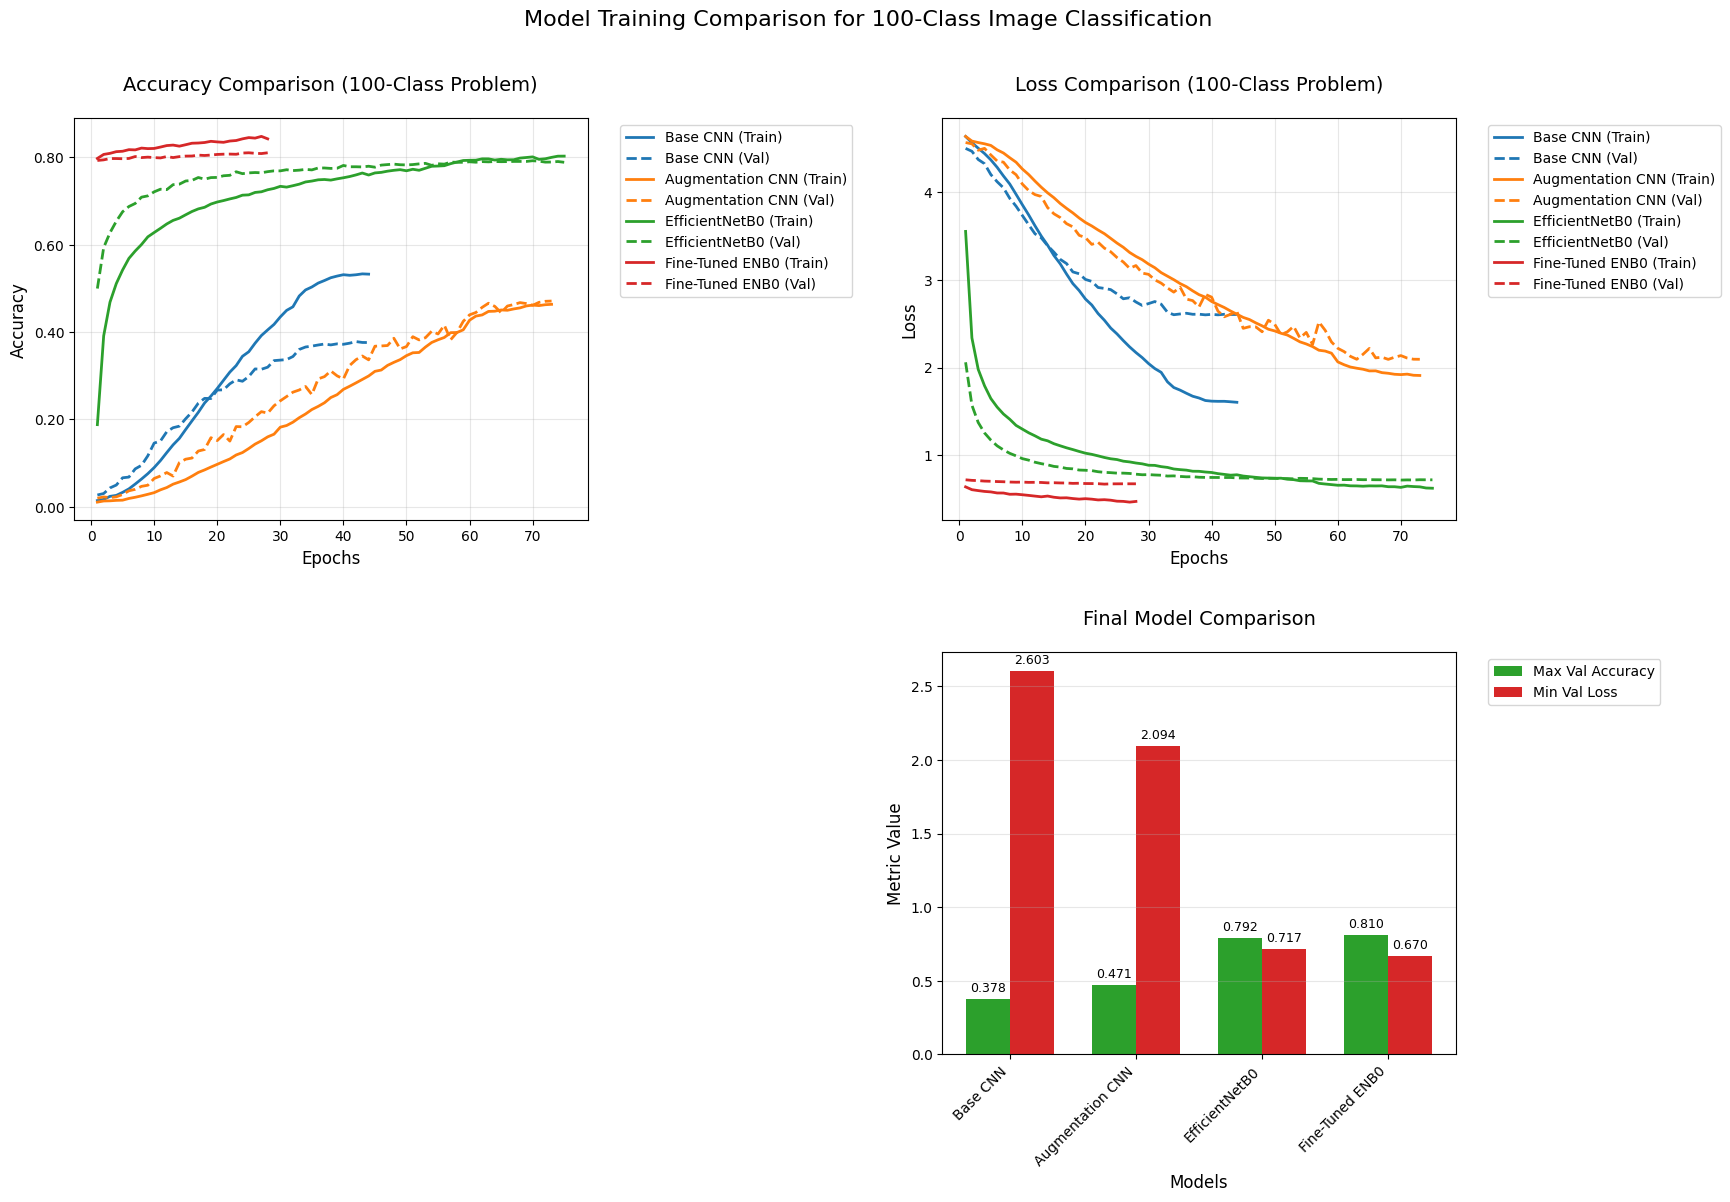

In [ ]:
histories = [history, history_2, history_3_ENB0, history_4_fine_ENB0]
model_names = [
    'Base CNN',
    'Augmentation CNN',
    'EfficientNetB0',
    'Fine-Tuned ENB0'
]

plot_training_histories(histories, model_names, num_classes=100)

In [ ]:
def plot_predictions(model, dataset, class_names, num_images=10):
    """
    Plot model predictions with color-coded labels (green=correct, red=incorrect)

    Args:
        model: Trained Keras model
        dataset: Validation dataset
        class_names: List of class names
        num_images: Number of images to display
    """
    # Get a batch from the validation dataset
    for images, labels in dataset.take(1):
        # Make predictions
        predictions = model.predict(images)
        predicted_labels = tf.argmax(predictions, axis=1)
        true_labels = tf.argmax(labels, axis=1)

        # Create plot
        plt.figure(figsize=(20, 12))

        # Plot images with predictions
        for i in range(min(num_images, len(images))):
            plt.subplot(2, 5, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))

            # Get labels info
            pred_class = class_names[predicted_labels[i]]
            true_class = class_names[true_labels[i]]
            confidence = np.max(predictions[i]) * 100

            # Set title color
            color = 'green' if predicted_labels[i] == true_labels[i] else 'red'

            # Create title
            title = f"Pred: {pred_class}\nTrue: {true_class}\nConf: {confidence:.1f}%"
            plt.title(title, color=color, fontsize=10)
            plt.axis('off')

        plt.suptitle(f"Fine-Tuned ENB0 Predictions on Validation Set\n(Green=Correct, Red=Incorrect)",
                    fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()

        # Print accuracy
        accuracy = np.mean(predicted_labels == true_labels)
        print(f"Batch Accuracy: {accuracy:.2%}")

        # Confusion matrix (optional)
        if len(class_names) <= 20:  # Only show if reasonable number of classes
            cm = confusion_matrix(true_labels, predicted_labels)
            print("\nConfusion Matrix:")
            print(cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


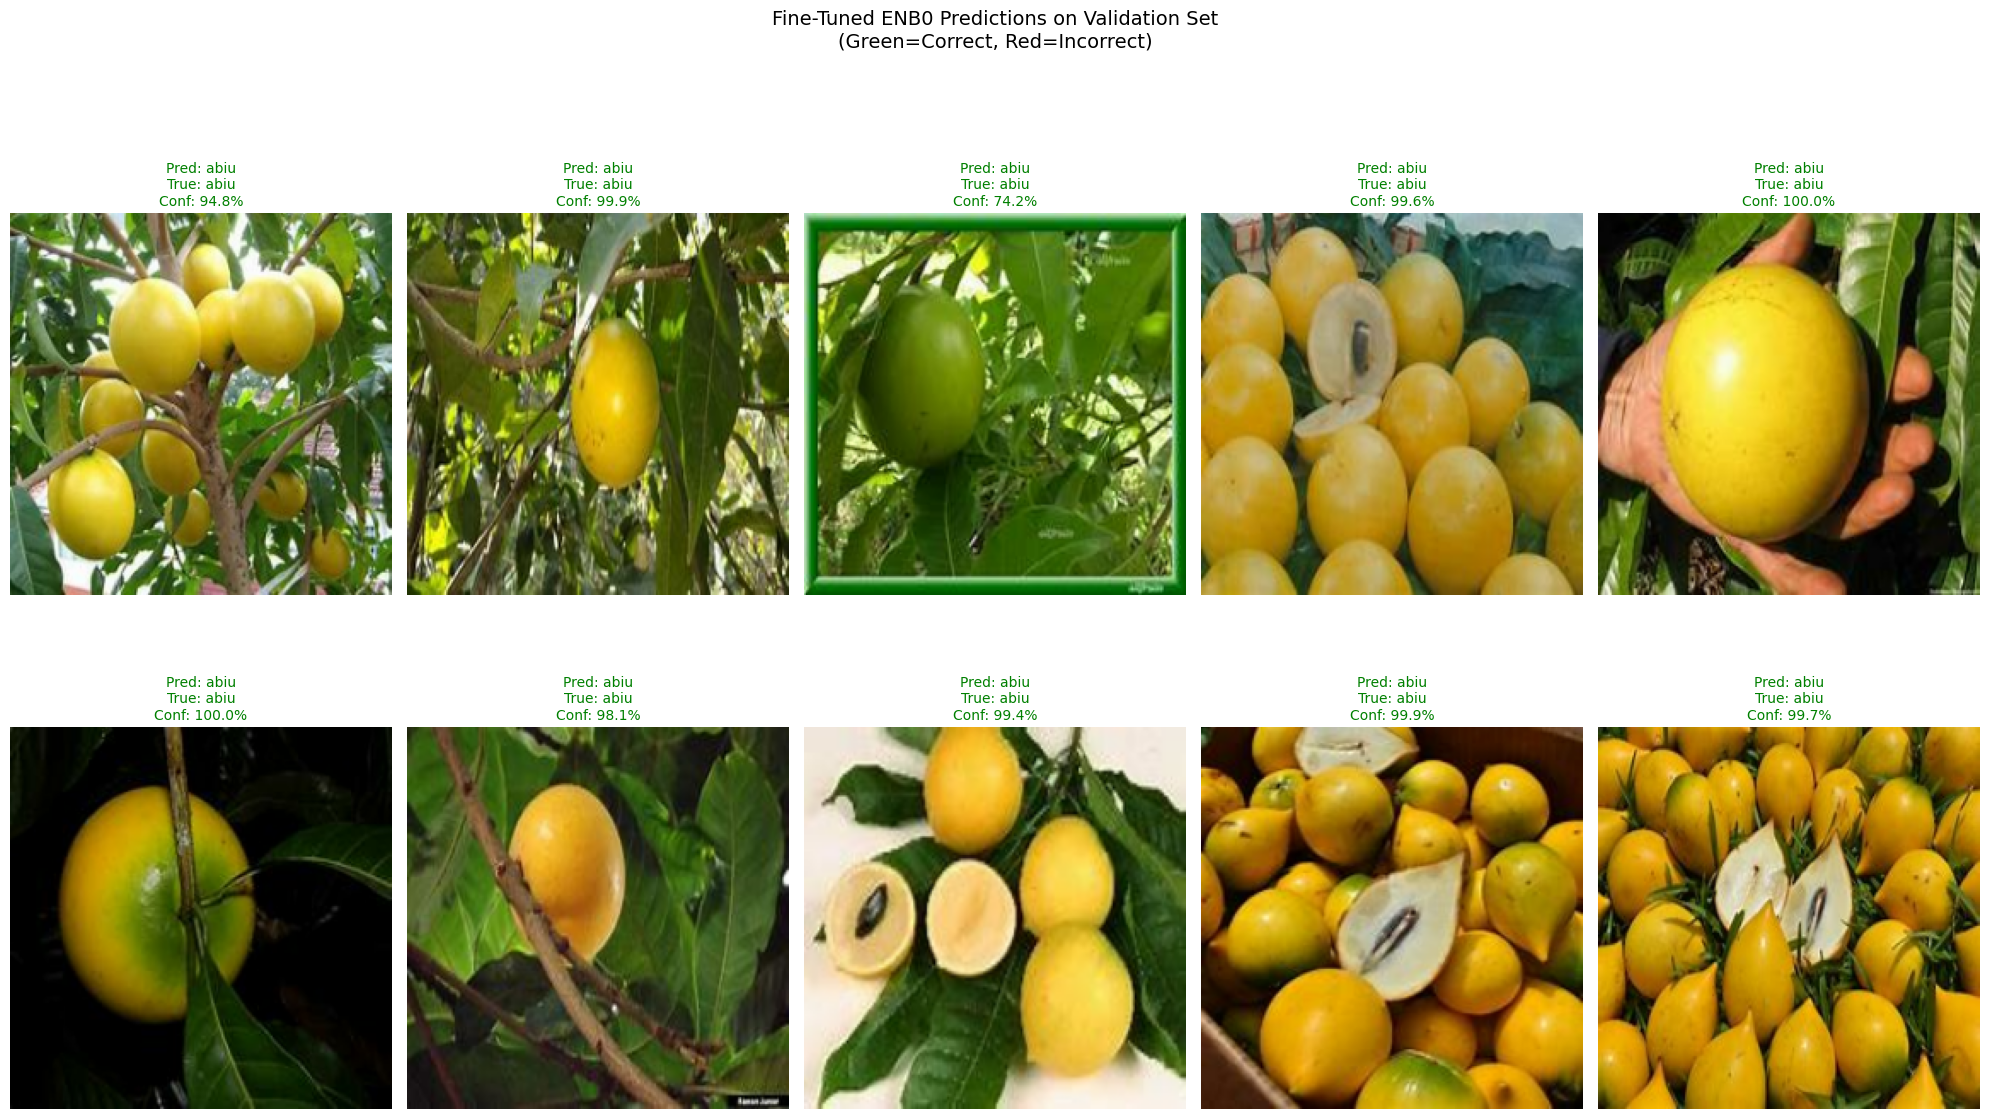

Batch Accuracy: 93.75%


In [ ]:
plot_predictions(model_3, val_dataset, class_names, num_images=10)

In [ ]:
def plot_predictions(model, dataset, class_names, num_images=10):
    """
    Plot model predictions with color-coded labels (green=correct, red=incorrect)
    Shows different random images each time the function is run.

    Args:
        model: Trained Keras model
        dataset: Validation dataset
        class_names: List of class names
        num_images: Number of images to display
    """
    # Collect all images and labels from the dataset
    all_images = []
    all_labels = []

    for images, labels in dataset.unbatch():
        all_images.append(images)
        all_labels.append(labels)

    # Convert to numpy arrays
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)

    # Randomly select images
    random_indices = random.sample(range(len(all_images)), min(num_images, len(all_images)))
    selected_images = all_images[random_indices]
    selected_labels = all_labels[random_indices]

    # Make predictions
    predictions = model.predict(selected_images)
    predicted_labels = tf.argmax(predictions, axis=1)
    true_labels = tf.argmax(selected_labels, axis=1)

    # Create plot
    plt.figure(figsize=(20, 12))

    # Plot images with predictions
    for i in range(len(random_indices)):
        plt.subplot(2, 5, i+1)
        plt.imshow(selected_images[i].astype("uint8"))

        # Get label info
        pred_class = class_names[predicted_labels[i]]
        true_class = class_names[true_labels[i]]
        confidence = np.max(predictions[i]) * 100

        # Set title color based on correctness
        color = 'green' if predicted_labels[i] == true_labels[i] else 'red'

        # Create title text
        title = f"Pred: {pred_class}\nTrue: {true_class}\nConf: {confidence:.1f}%"
        plt.title(title, color=color, fontsize=10)
        plt.axis('off')

    plt.suptitle(f"Fine-Tuned ENB0 Predictions on Validation Set\n(Green=Correct, Red=Incorrect)",
                fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # Print accuracy for this sample
    accuracy = np.mean(predicted_labels == true_labels)
    print(f"Sample Accuracy: {accuracy:.2%}")

    # Confusion matrix (optional)
    if len(class_names) <= 20:  # Only show if reasonable number of classes
        cm = confusion_matrix(true_labels, predicted_labels)
        print("\nConfusion Matrix:")
        print(cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


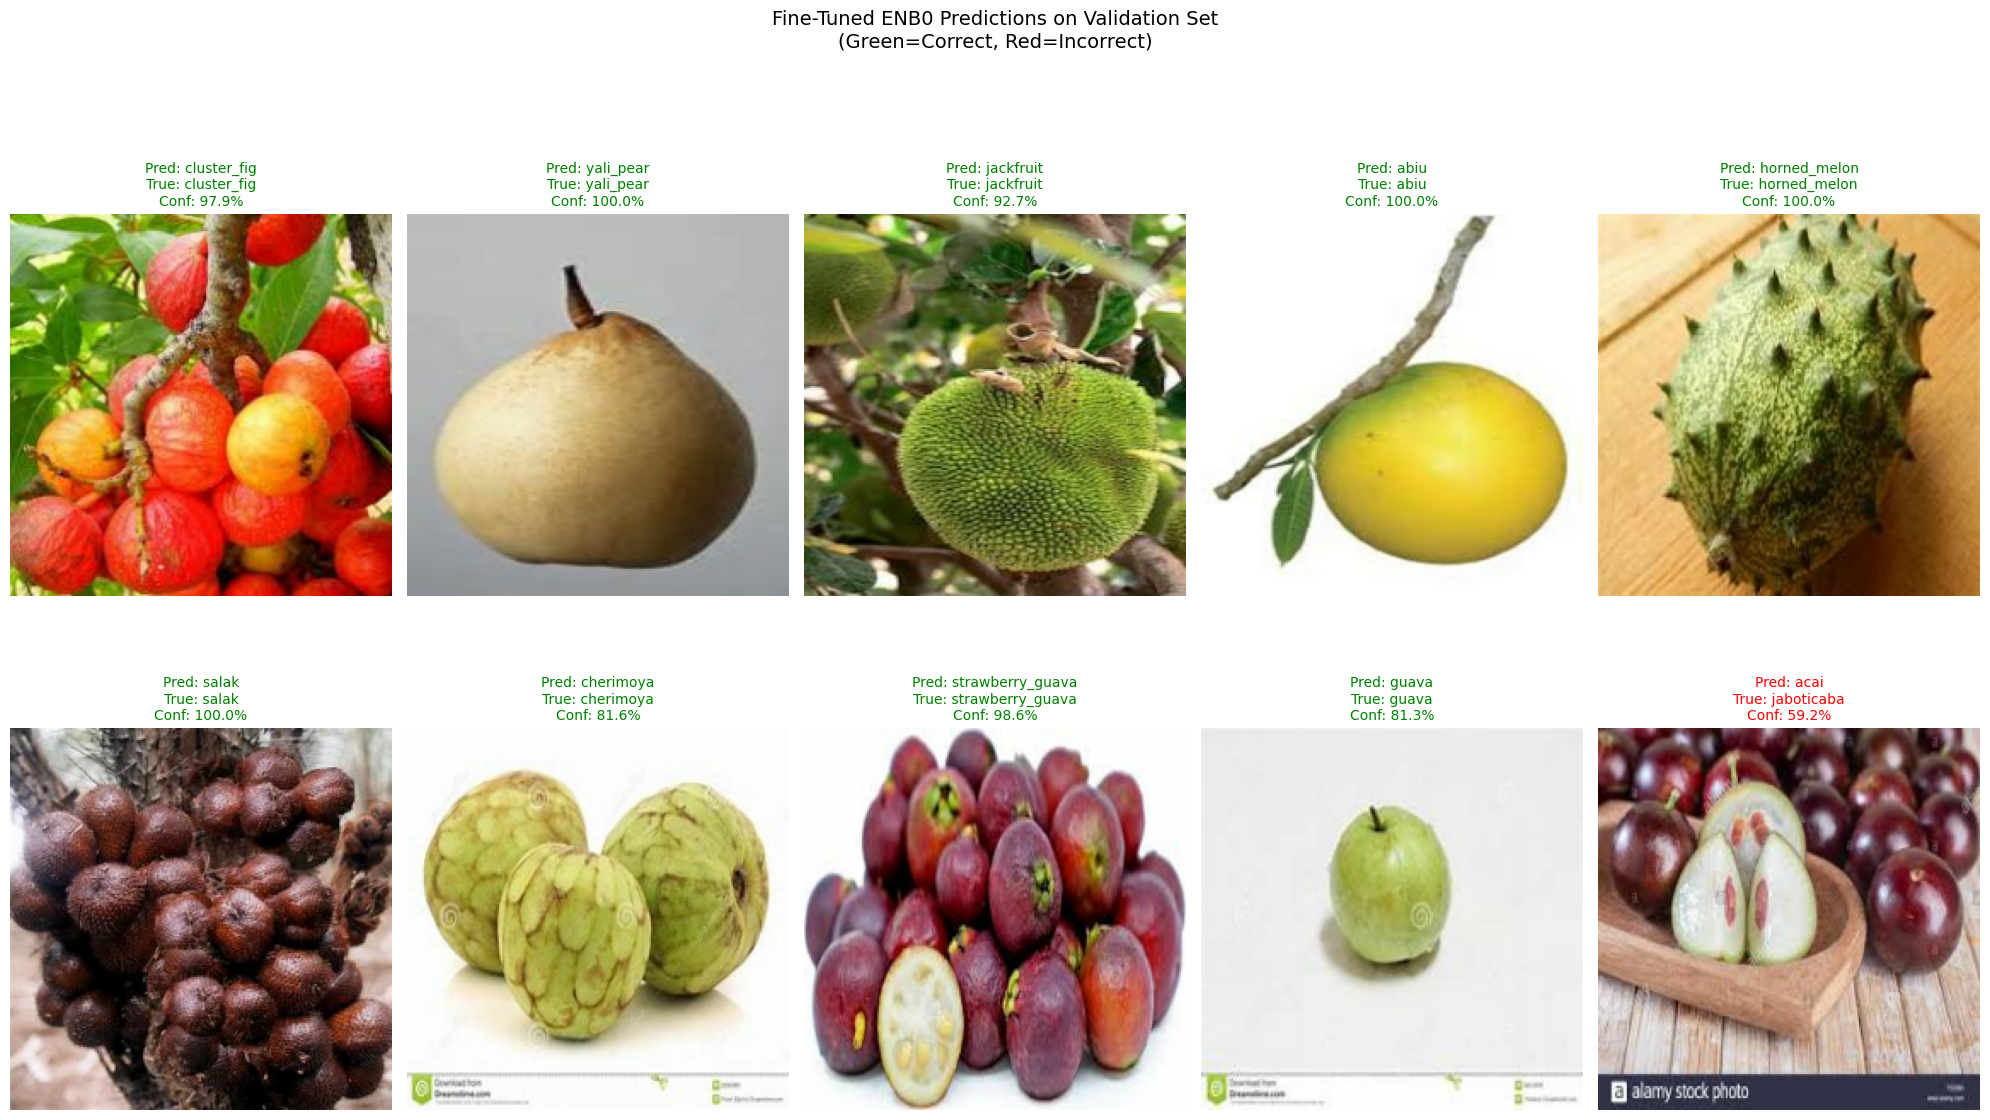

Sample Accuracy: 90.00%


In [ ]:
plot_predictions(model_3, val_dataset, class_names, num_images=10)